# <center> CSE 4/546: Reinforcement Learning
## Assignment 3 - Actor-Critic
### Part - 3: Solving Complex Environments (Acrobot & BipedalWalker)

<b>Submitted By:</b><br>
Name - Shivansh Gupta<br>
UBIT No - 50604127<br>
UBIT Name - sgupta67<br>
UB Email ID - sgupta67@buffalo.edu<br>

Name - Karan Ramchandani<br>
UBIT No - 50610533<br>
UBIT Name - karamchan<br>
UB Email ID - karamchan@buffalo.edu<br>

#### Importing Required Libraries

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import time
import threading
import pickle
import numpy as np
from torch.distributions import Categorical
from multiprocessing import Manager

### 1) Gym `Acrobot-v1`

#### Creating the required Neural Network for the A2C Model

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
        )
        self.actor  = nn.Linear(hidden_dim, act_dim)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.shared(x)
        return self.actor(h), self.critic(h)

In [3]:
def reset_env(env, device):
    out = env.reset()
    obs = out[0] if isinstance(out, tuple) else out
    obs = np.array(obs, dtype=np.float32)
    return torch.from_numpy(obs).to(device)


def step_env(env, action, device):
    out = env.step(action)
    if len(out) == 5:
        next_obs, reward, term, trunc, _ = out
        done = term or trunc
    else:
        next_obs, reward, done, _ = out
    next_obs = np.array(next_obs, dtype=np.float32)
    return torch.from_numpy(next_obs).to(device), reward, done


# Shared Adam from A3C example so optimizer state lives in shared memory
class SharedAdam(optim.Adam):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)
                # share in memory
                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

    def share_memory(self):
        return self


In [ ]:
env_name      = "Acrobot-v1"
gamma         = 0.99
lr            = 3e-4
n_steps       = 5
max_episodes  = 10000
hidden_dim    = 128
ent_coef      = 1e-2
vf_coef       = 0.5
max_grad_norm = 0.5
num_workers   = 4

In [4]:
def worker(rank, global_model, optimizer, grad_ready,
                  grad_lock, reward_list, device):
    torch.manual_seed(1000 + rank)
    env = gym.make(env_name)
    local_model = ActorCritic(global_model.shared[0].in_features,
                              global_model.actor.out_features,
                              hidden_dim).to(device)
    local_model.load_state_dict(global_model.state_dict())

    episodes_per_worker = max_episodes // num_workers
    for ep in range(1, episodes_per_worker + 1):
        obs = reset_env(env, device)
        total_reward = 0.0
        done = False

        # Keep rolling out n-step segments until the episode ends
        while not done:
            # ← Reset segment buffers
            log_probs, values, rewards, masks, entropies = [], [], [], [], []

            # Collect up to n_steps or until done
            for _ in range(n_steps):
                logits, value = local_model(obs)
                dist = Categorical(logits=logits)
                action = dist.sample()

                next_obs, reward, done = step_env(env, action.item(), device)
                total_reward += reward  # ← accumulate full-episode return

                log_probs.append(dist.log_prob(action))
                values.append(value.squeeze())
                rewards.append(torch.tensor(reward, device=device))
                masks.append(0.0 if done else 1.0)
                entropies.append(dist.entropy())

                obs = next_obs
                if done:
                    break  # episode has ended

            # Bootstrap final value
            with torch.no_grad():
                _, next_value = local_model(obs)
                R = next_value.squeeze()

            # Compute n-step returns & losses for this segment
            returns = []
            for r, m in zip(reversed(rewards), reversed(masks)):
                R = r + gamma * R * m
                returns.insert(0, R)
            returns   = torch.stack(returns)
            values_t  = torch.stack(values)
            logp_t    = torch.stack(log_probs)
            ent_t     = torch.stack(entropies)
            adv       = returns - values_t

            actor_loss   = -(logp_t * adv.detach()).mean()
            critic_loss  = adv.pow(2).mean()
            entropy_loss = -ent_t.mean()
            loss = actor_loss + vf_coef * critic_loss + ent_coef * entropy_loss

            # Backprop on local model & push gradients
            local_model.zero_grad()
            loss.backward()
            grads = [p.grad.clone() for p in local_model.parameters()]

            scaled = [g / num_workers for g in grads]

            with grad_lock:
                # accumulate into global_model.grad
                for p, g in zip(global_model.parameters(), scaled):
                    if p.grad is None:
                        p.grad = g.to(device)
                    else:
                        p.grad += g.to(device)

                # increment the ready counter
                grad_ready.value += 1

                # if this was the last worker to arrive, step & reset
                if grad_ready.value == num_workers:
                    optimizer.step()
                    optimizer.zero_grad()
                    grad_ready.value = 0

            # reload updated parameters before next rollout
            local_model.load_state_dict(global_model.state_dict())

        # ← Episode has terminated: now we have the full-episode return
        if rank == 0 and ep % 50 == 0:
            print(f"Episode {ep}/{episodes_per_worker}  Total Episode Reward: {total_reward:.2f}")
        
        reward_list.append(total_reward)

        # next loop iteration will reset the env automatically
    env.close()

In [8]:
def worker_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # create & share global model
    test_obs = gym.make(env_name).observation_space.sample()
    obs_dim  = np.array(test_obs).shape[0]
    act_dim  = gym.make(env_name).action_space.n
    global_model = ActorCritic(obs_dim, act_dim, hidden_dim).to(device)
    global_model.share_memory()

    optimizer = SharedAdam(global_model.parameters(), lr=lr)
    barrier   = mp.Barrier(num_workers)
    grad_queue = mp.Queue()

    manager     = Manager()
    grad_ready  = manager.Value("i", 0)    
    grad_lock   = manager.Lock() 
    reward_list = manager.list()         
    print("====Training Started====")
    processes = []
    for rank in range(num_workers):
        print(f"Worker No. {rank+1} is Started")
        p = mp.Process(
            target=worker,
            args=(rank,
                global_model,
                optimizer,
                grad_ready,
                grad_lock,
                reward_list,
                device)
        )
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    rewards = list(reward_list)
    checkpoint = {
        'state_dict': global_model.state_dict(),
        'rewards':    rewards
    }

    with open('New_Code/Weights/Acrobat_A2C_Weights.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Saved model + {len(rewards)} episode‑rewards to Acrobat_A2C_Weights.pkl")

    print("====Training complete====")

In [ ]:
mp.set_start_method("spawn") 
worker_training()

In [10]:
model_weights = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
rewards = model_weights['rewards']

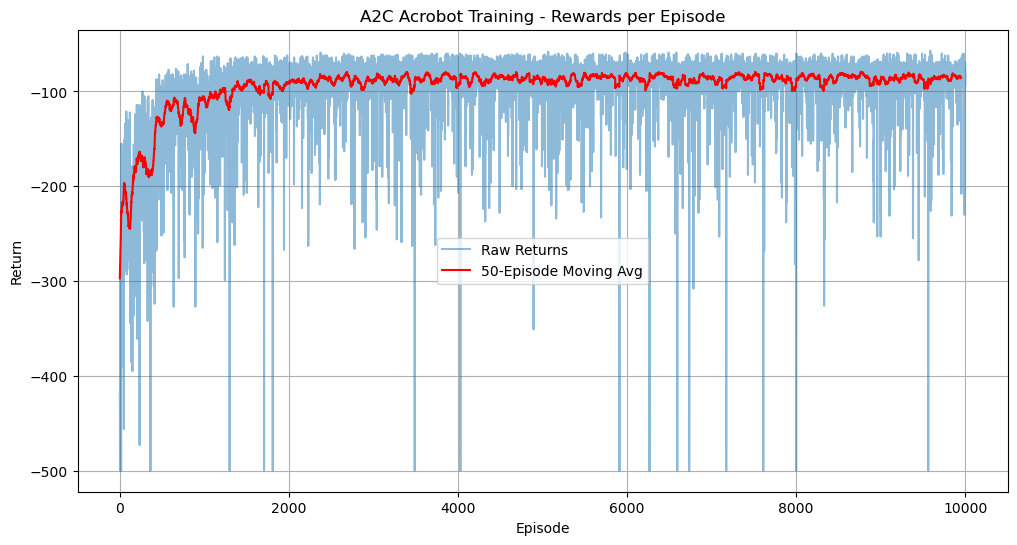

In [15]:
# Plotting the rewards over the episodes as a smoothened trend
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Raw Returns')
smooth_ret = np.convolve(rewards, np.ones(50)/50, mode='valid')
plt.plot(smooth_ret, label='50-Episode Moving Avg', color='red')
plt.title("A2C Acrobot Training - Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()

In [19]:
test_env = gym.make('Acrobot-v1')
observation_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n
test_env.close()

# Initializing the network
test_model = ActorCritic(observation_dim, action_dim, hidden_dim)

# Loading the trained model weights
checkpoint = pickle.load(open('a3_part_2_a2c_acrobot_sgupta67_karamchan.pkl', 'rb'))
test_model.load_state_dict(checkpoint['state_dict'])
test_model.eval()

greedy_rewards = []

# Testing the trained model for 10 episodes
for ep in range(10):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logit, value = test_model(state_t)
        distributions = torch.distributions.Categorical(logits=logit)
        action_taken = distributions.sample()
        next_state, reward, terminated, truncated, _ = test_env.step(action_taken.item())
        done = truncated or terminated
        total_reward += reward
        state = next_state
        
    print(f"Episode: {ep} Total_reward: {total_reward}")
    greedy_rewards.append(total_reward)
    test_env.close()

Episode: 0 Total_reward: -68.0
Episode: 1 Total_reward: -92.0
Episode: 2 Total_reward: -102.0
Episode: 3 Total_reward: -75.0
Episode: 4 Total_reward: -79.0
Episode: 5 Total_reward: -101.0
Episode: 6 Total_reward: -76.0
Episode: 7 Total_reward: -70.0
Episode: 8 Total_reward: -109.0
Episode: 9 Total_reward: -86.0


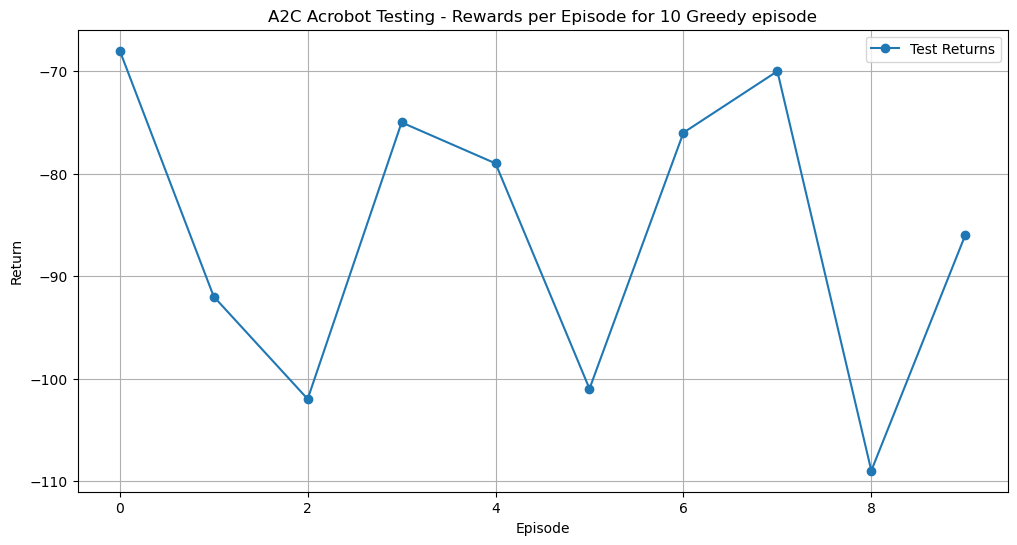

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(greedy_rewards, marker='o', label='Test Returns')
plt.title("A2C Acrobot Testing - Rewards per Episode for 10 Greedy episode")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()